**Key Characteristics of CasCN:**

1. Temporal Convolutions: CasCN applies CNN layers on time-series data to detect temporal dependencies and capture local features within time windows.

2. Pooling Layers: By using pooling operations, it reduces the dimensionality and retains significant features, aiding generalization and computational efficiency.

3. Flattening and Dense Layers: After convolutional and pooling layers, CasCN flattens the data and feeds it through dense (fully connected) layers, enabling it to learn nonlinear relationships between features for final predictions.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/combined_data.csv')

In [ ]:
# Step 2: Create Cascade Size
# Derive cascade size by counting occurrences of each tweet_id
df['cascade_size'] = df.groupby('tweet_id')['tweet_id'].transform('count')

In [ ]:
# Step 3: Preprocessing
# Feature Selection
features = ['relative_time_second', 'number_of_followers']
target = 'cascade_size'

In [ ]:
# Handling Missing Values
df.dropna(subset=features + [target], inplace=True)

In [ ]:
# Normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features].values)

In [ ]:
# Prepare target variable
y = df[target].values

In [ ]:
# Reshape Data for Conv1D
X = X.reshape((X.shape[0], X.shape[1], 1))  # Conv1D input shape: (samples, timesteps, features)

In [ ]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 4: Define the CasCN Model with Conv1D Layers
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

In [ ]:
# Convolutional and Pooling Layers
conv_out = Conv1D(64, kernel_size=1, activation='relu')(input_layer)
conv_out = MaxPooling1D(pool_size=1)(conv_out)
conv_out = Dropout(0.2)(conv_out)
conv_out = Conv1D(32, kernel_size=1, activation='relu')(conv_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)
conv_out = Dropout(0.2)(conv_out)

In [ ]:
# Flatten the output for Dense layers
flat_out = Flatten()(conv_out)

In [ ]:
# Fully Connected Layers
dense_out = Dense(64, activation='relu')(flat_out)
dense_out = Dropout(0.2)(dense_out)
output_layer = Dense(1, activation='linear')(dense_out)

In [ ]:
# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Step 5: Train the Model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Fit the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 167s 2ms/step - loss: 2921456.7500 - val_loss: 2839040.7500
Epoch 2/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 180s 3ms/step - loss: 2886456.0000 - val_loss: 2820949.0000
Epoch 3/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 193s 3ms/step - loss: 2889872.5000 - val_loss: 2810612.7500
Epoch 4/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 153s 2ms/step - loss: 2861634.7500 - val_loss: 2809661.0000
Epoch 5/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 218s 2ms/step - loss: 2842639.5000 - val_loss: 2808861.2500
Epoch 6/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 184s 2ms/step - loss: 2860666.2500 - val_loss: 2809959.0000
Epoch 7/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 203s 2ms/step - loss: 2889732.7500 - val_loss: 2808417.0000
Epoch 8/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 153s 2ms/step - loss: 2844759.7500 - val_loss: 2806862.5000
Epoch 9/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 170s 2ms/step - loss: 2846061.0000 - val_loss: 2806151.7500
Epoch 10/20
68340/68340 ━━━━━━━━━━━━━━━━━━━━ 154s 2ms/step - los

In [ ]:
# Step 6: Evaluate the Model on Test Data
y_pred = model.predict(X_test)

21357/21357 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step


In [ ]:
# Calculate Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 2803635.7144296877
Mean Absolute Error: 766.2051094680688


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


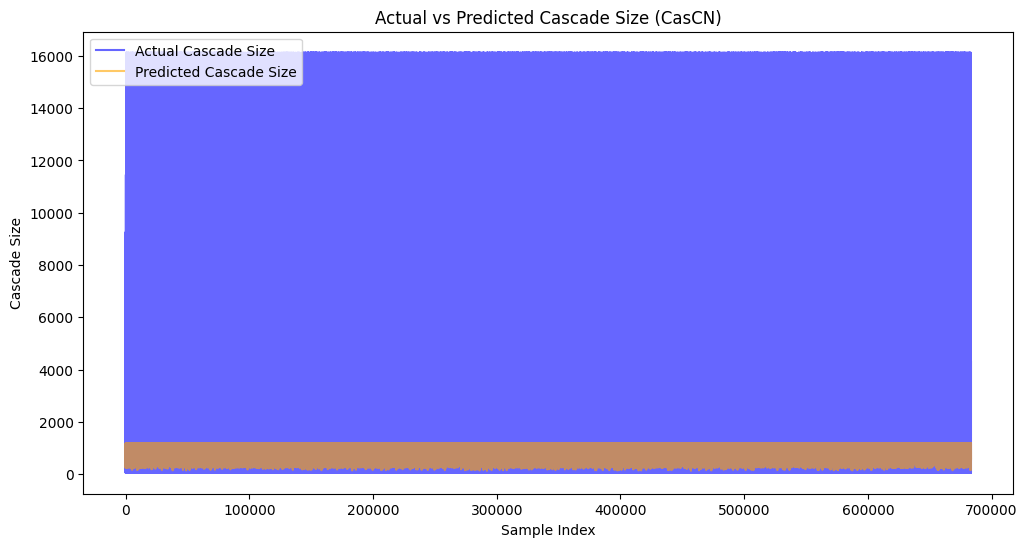

In [ ]:
# Step 7: Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Cascade Size', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Cascade Size', color='orange', alpha=0.6)
plt.title('Actual vs Predicted Cascade Size (CasCN)')
plt.xlabel('Sample Index')
plt.ylabel('Cascade Size')
plt.legend()
plt.show()

1. This high MSE suggests that, on average, the squared differences between your model's predictions and actual cascade sizes are large, implying significant variation between predicted and true cascade sizes.

Implication: MSE is sensitive to large errors due to squaring, so it disproportionately penalizes larger prediction errors. This value indicates that there may be some large deviations in specific predictions.

2. This MAE indicates that, on average, the model’s predictions are off by around 766 cascade units (e.g., retweets, followers) from the actual values.

Implication: MAE gives a straightforward understanding of prediction errors in the units of the target variable (cascade size) without exaggerating the effect of large errors.